# Labor Condition Applications

As part of the H1B Visa application process, each sponsoring company must submit a Labor Condition Application (LCA) to the United States Department of Labor. With this application, the employer must show, amongst other things, that the non-immigrant worker who is applying for the H1B is being paid similarly to employees at the company doing the same work, and is receiving the prevailing wage for that occupation in the geographical area.

The Department of Labor provides a record of all submitted LCAs each year [on their website.](http://www.foreignlaborcert.doleta.gov/performancedata.cfm#dis) Along with general wage information from the department's [Bureau of Labor Statistics,](http://www.bls.gov/soc/) I've analyzed the data from 2014 to determine trends in LCA wages and the number of applications.

The data used in this notebook, though downloaded from open sources, has been pre-processed by myself. To see the steps I took in doing so, please see the other associated notebook files. In many cases, outliers have been removed from the data regardless of whether they were the result of errors in the data or actually extreme values. Because this analysis is focused on broad trends in the hundreds of thousands of applicants from 2014, omitting these values will not negatively impact my analysis. 

In [1]:
import csv
from bs4 import BeautifulSoup
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The input code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the input code, click <a href="javascript:code_toggle()">here</a>.''')

## Part I - Wage Analysis

Although the Department of Labor (DOL) states that H1B applicants must be paid similarly to their domestic counterparts, I was curious to see if this was true in all cases. Furthermore, I wanted to see if there were any trends in this data, such as specific employers, industries, or occupations paying foreign workers differently.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

f = open("Delta_LCA.csv", "r")
delta_df = pd.read_csv(f, index_col=0)
f.close()

In terms of wage types, there are two major categories in the data: **hourly** and **yearly**. By plotting these groups, we can get a sense of the prevailing wages of these applicants. The mean and median US wages are sourced from the [Office of Social Security.](http://www.ssa.gov/oact/cola/central.html) When comparing hourly wages to the US national mean and median, I assume a 2087 hour work year, as specified by the [Office of Personnel Management.](http://www.opm.gov/policy-data-oversight/pay-leave/pay-administration/fact-sheets/computing-hourly-rates-of-pay-using-the-2087-hour-divisor/)

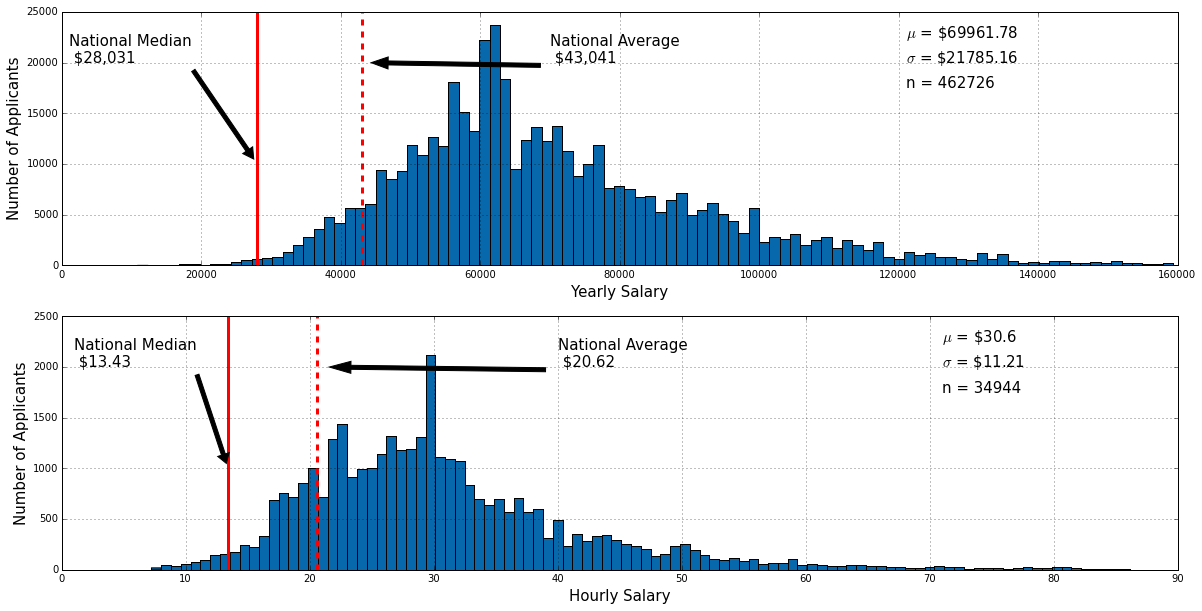

In [3]:
yearly_wages = delta_df["PW_1"][delta_df["PW_UNIT_1"] == "Year"]
hourly_wages = delta_df["PW_1"][delta_df["PW_UNIT_1"] == "Hour"]

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(yearly_wages, bins=100, color="#0868ac")
plt.xlabel("Yearly Salary", fontsize=15)
plt.ylabel("Number of Applicants", fontsize=15)
plt.grid(True)
plt.axvline(x=43041, ymin=0, ymax=25000, color="red", ls="--", linewidth="3")
plt.annotate('National Average \n $43,041', fontsize=15, xy=(43041, 20000), xytext=(70000, 20000),
            arrowprops=dict(facecolor='black', shrink=.05))
plt.axvline(x=28031, ymin=0, ymax=25000, color="red", ls="-", linewidth="3")
plt.annotate('National Median \n $28,031', fontsize=15, xy=(28031, 10000), xytext=(1000, 20000),
            arrowprops=dict(facecolor='black', shrink=.05))
plt.text(121000, 22500, "$\mu$ = \$" + str(round(yearly_wages.mean(), 2)), fontsize=15)
plt.text(121000, 20000, "$\sigma$ = \$" + str(round(yearly_wages.std(), 2)), fontsize=15)
plt.text(121000, 17500, "n = " + str(len(yearly_wages)), fontsize=15)


plt.subplot(212)
plt.hist(hourly_wages.values, bins=100, color="#0868ac")
plt.xlabel("Hourly Wage", fontsize=15)
plt.ylabel("Number of Applicants", fontsize=15)
plt.grid(True)
plt.axvline(x=20.62, ymin=0, ymax=2500, color="red", ls="--", linewidth="3")
plt.annotate('National Average \n $20.62', fontsize=15, xy=(20.62, 2000), xytext=(40, 2000),
            arrowprops=dict(facecolor='black', shrink=.05))
plt.axvline(x=13.43, ymin=0, ymax=2500, color="red", ls="-", linewidth="3")
plt.annotate('National Median \n $13.43', fontsize=15, xy=(13.42, 1000), xytext=(1, 2000),
            arrowprops=dict(facecolor='black', shrink=.05))
plt.text(71, 2250, "$\mu$ = \$" + str(round(hourly_wages.mean(), 2)), fontsize=15)
plt.text(71, 2000, "$\sigma$ = \$" + str(round(hourly_wages.std(), 2)), fontsize=15)
plt.text(71, 1750, "n = " + str(len(hourly_wages)), fontsize=15)

plt.show()

It is immediately apparent that foreign workers make much more than the typical American. However, these graphs do not take into account occupation and location. It would make sense that foreign workers are more often hired for high-skill, specialist positions for which the supply of domestic workers is limited. Since these positions command a higher wage, this would explain both the higher than average wage for H1B applicants and the rightward skew in both wage distributions. Furthermore, since these positions tend to be salaried, it also explains the fact that there are over ten times as many salaried H1B applicants than hourly.

Again, these graphs are not a fair representation of the wages of foreign vs. domestic workers. A more accurate metric would be the difference in wage between workers from the same state performing the same job. Each application has a Standard Occupational Classification (SOC) code which states the job function of the applicant. The Bureau of Labor Statistics also has data on the average wages for each of these codes in each state. Using these values, I can calculate the difference from the average, or delta ($\Delta$) for each applicant as a percentage. This will be the metric I use to analyze the wages of H1B applicants.

Note: For analyzing wages, I will only be examining applications that were certified by the Department of Labor.

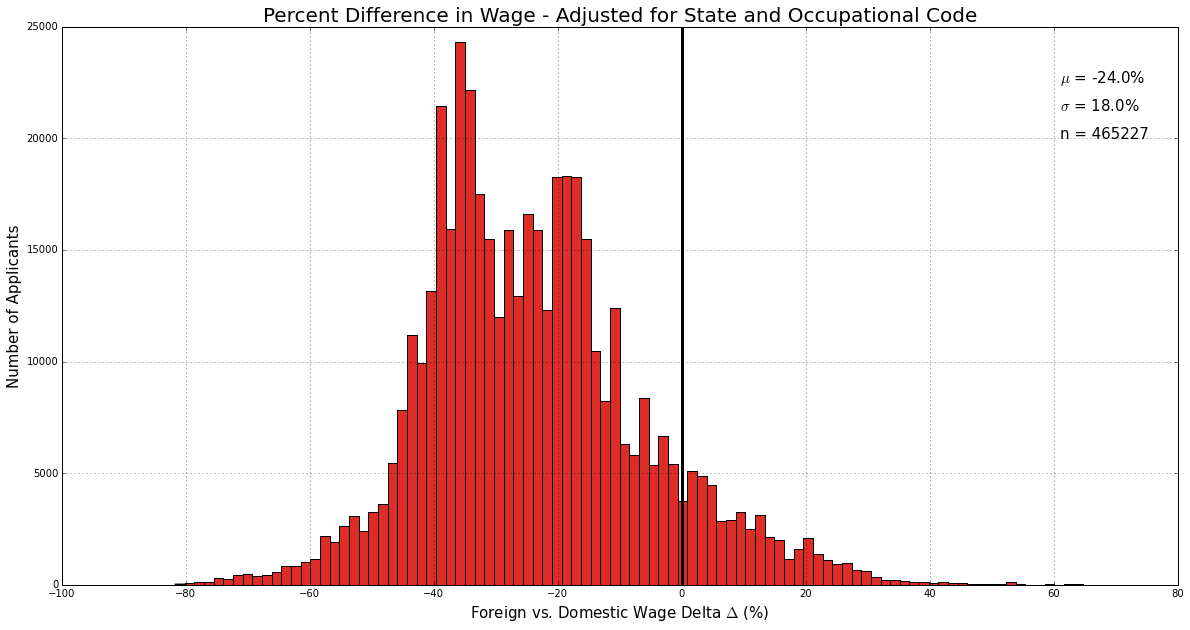

In [4]:
certified_delta_df = delta_df[delta_df.STATUS.str.contains("CERTIFIED")]

state_delta = certified_delta_df["STATE_DELTA"].dropna()

state_delta = state_delta[state_delta < state_delta.quantile(.9999)]   # Remove the most extreme outliers.
state_delta = state_delta[state_delta > state_delta.quantile(.0001)]

plt.figure(figsize=(20,10))

plt.hist(state_delta.values*100, bins=100, color = "#de2d26")
plt.title("Percent Difference in Wage - Adjusted for State and Occupational Code", fontsize=20)
plt.xlabel("Foreign vs. Domestic Wage Delta $\Delta$ (%)", fontsize=15)
plt.ylabel("Number of Applicants", fontsize=15)
plt.grid(True)
plt.axvline(x=0, ymin=0, ymax=30000, color="black", ls="-", linewidth="3")
plt.text(61, 22500, "$\mu$ = " + str(round(state_delta.mean(), 2)*100) + "%", fontsize=15)
plt.text(61, 21250, "$\sigma$ = " + str(round(state_delta.std(), 2)*100) + "%", fontsize=15)
plt.text(61, 20000, "n = " + str(len(state_delta)), fontsize=15)

plt.show()

This graph tells a very different story than the previous two. According to the data, foreign workers are typically paid 24% less than their domestic counterparts. With the given mean and standard deviation, only about 9% of foreign workers make as much as or more than domestic workers performing the same job in the same state. Furthermore, some states tend to pay foreigners less than others.

Note: This data includes Guam ("GU"), the Virgin Islands ("VI) and Puerto Rico ("PR"). In the map below, darker colors represent a larger discrepancy.

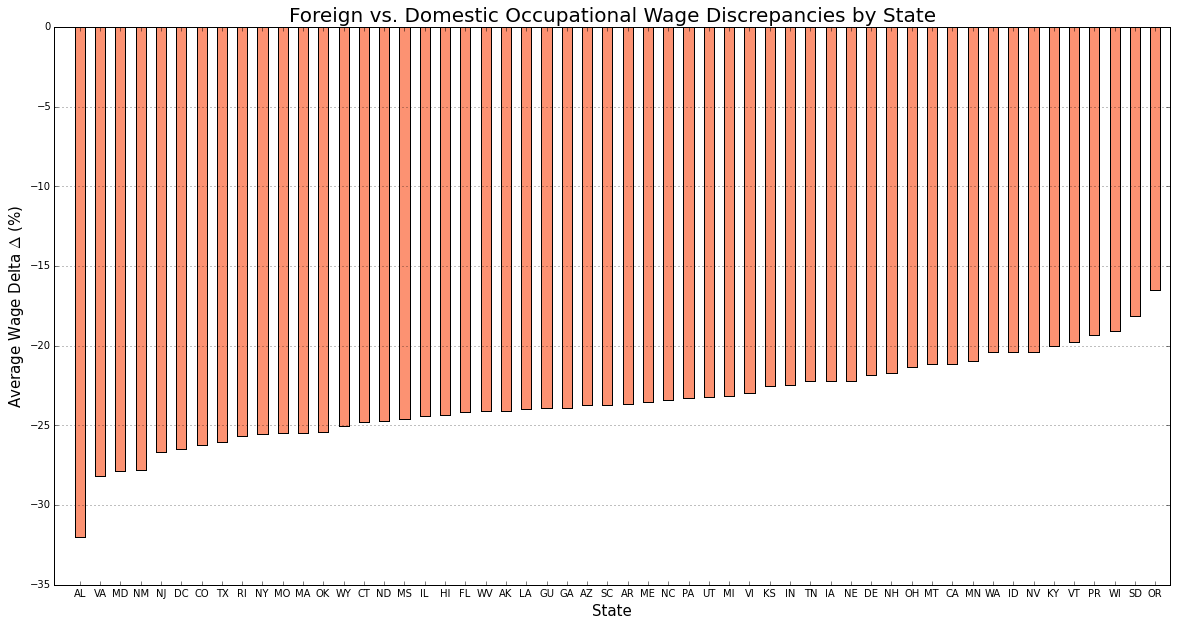

In [5]:
delta_grouped_by_state = certified_delta_df.groupby(["STATE"])
deltas_by_state = delta_grouped_by_state["STATE_DELTA"].mean().order("STATE_DELTA").dropna()
names = deltas_by_state.keys().tolist()

lefts = range(1,len(deltas_by_state)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))
    

plt.bar(lefts, deltas_by_state.values*100, width=bar_widths, color="#fc9272")
plt.grid(True, axis="y")
plt.title("Foreign vs. Domestic Occupational Wage Discrepancies by State", fontsize=20)
plt.xlim(0, 55)
plt.xticks([0.25+x for x in lefts], names)
plt.xlabel("State", fontsize=15)
plt.ylabel("Average Wage Delta $\Delta$ (%)", fontsize=15)

plt.show()

In [6]:
svg = open('Blank_US_Map.svg', 'r').read()

# Load into Beautiful Soup
soup = BeautifulSoup(svg, selfClosingTags=['defs','sodipodi:namedview'])
paths = soup.findAll('path')

colors = ["#fee5d9", "#fcbba1","#fc9272", "#fb6a4a", "#de2d26", "#a50f15"]

# State style
path_style = """font-size:12px;fill-rule:nonzero;stroke:#000000;stroke-opacity:1;
stroke-width:0.2;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;
marker-start:none;stroke-linejoin:bevel;fill:"""
 
# Color the counties based on Delta
for p in paths:
    try: state = p["id"]
    except: continue
    if state == "SP-": state = "MI"
    if state == "MI-": state = "MI"    
    try:
       delta = deltas_by_state[state]
    except:
       continue
             
         
    if delta < -.300:
        color_class = 5
    elif delta < -.275:
        color_class = 4
    elif delta < -.250:
        color_class = 3
    elif delta < -.175:
        color_class = 2
    elif delta < -.150:
        color_class = 1
    else:
        color_class = 0
 
 
    color = colors[color_class]
    if state == "DC": soup.findAll('circle')[0]['style'] = path_style + color
    else: p['style'] = path_style + color
 
HTML(soup.prettify())

Alabama seems to pay foreign workers considerably worse than most states, while Oregon, averaging -16.5%, tends to pay H1B workers the closest to their domestic counterparts. In addition, individual industries and occupations show a wide range of wage discrepancy, regardless of state.

Although the best paying industry is an outlier (which I will explore shortly), the difference in Delta between the two worst and two next best industries is still substantial.

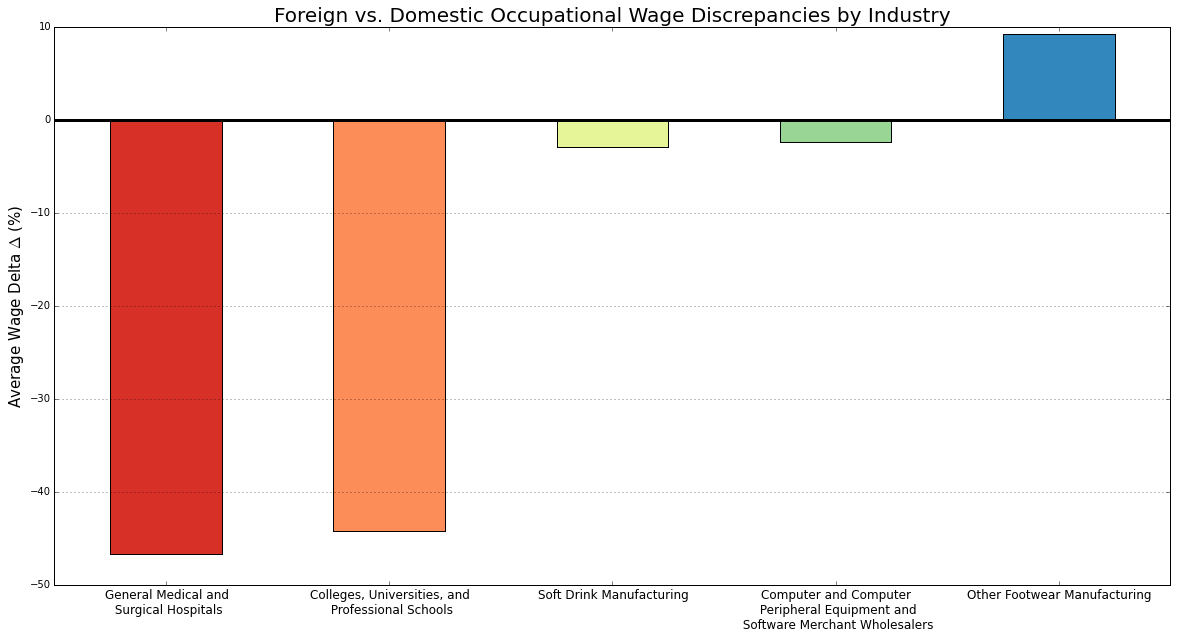

In [7]:
# Only industries with at least 100 applicants will be examined in this graph.

delta_grouped_by_industry = certified_delta_df.groupby(["LCA_CASE_NAICS_CODE"])
valid_industries = delta_grouped_by_industry.size()[delta_grouped_by_industry.size() > 100].keys()

valid_industry_df = certified_delta_df[certified_delta_df["LCA_CASE_NAICS_CODE"].isin(valid_industries)]
delta_grouped_by_industry = valid_industry_df.groupby(["LCA_CASE_NAICS_CODE"])
industry_deltas = delta_grouped_by_industry["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

industry_values = industry_deltas.head(2).values.tolist() + industry_deltas.tail(3).values.tolist()
industry_names = ["General Medical and \n Surgical Hospitals", "Colleges, Universities, and \n Professional Schools", 
                 "Soft Drink Manufacturing", 
                  "Computer and Computer \n Peripheral Equipment and \n Software Merchant Wholesalers",
                 "Other Footwear Manufacturing"]
colors = ["#d73027", "#fc8d59", "#e6f598", "#99d594", "#3288bd"]

lefts = range(1,len(industry_names)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))

plt.bar(lefts, [100*x for x in industry_values], width=bar_widths, color = colors)
plt.grid(True, axis="y")
plt.title("Foreign vs. Domestic Occupational Wage Discrepancies by Industry", fontsize=20)
plt.xticks([0.25+x for x in lefts], industry_names, fontsize=12)
plt.xlim(0.75, 5.75)
plt.ylabel("Average Wage Delta $\Delta$ (%)", fontsize=15)
plt.axhline(y=0, xmin=0, xmax=30000, color="black", ls="-", linewidth="3")

plt.show()


As it turns out, Hospitals and Universities are by far the worst when it comes to paying foreign workers fairly. In general, manufacturing and technology fields tend to pay their foreign workers fairly well. There is one very unusual outlier in "Other Footwear Manufacturing", however. This is because that particular industry is dominated by a single company, **Nike Inc**, which is headquartered in Oregon, the state with the lowest average wage delta. Furthermore, as the largest company in Oregon, it can be assumed that Nike would pay all of its employees a high wage relative to other companies in the state. Given this information, Nike seems to be a good choice of employer for foreigners looking to work in the United States.

Examining the difference in wages by Occupational Classification further highlights the extent of the pay gap.

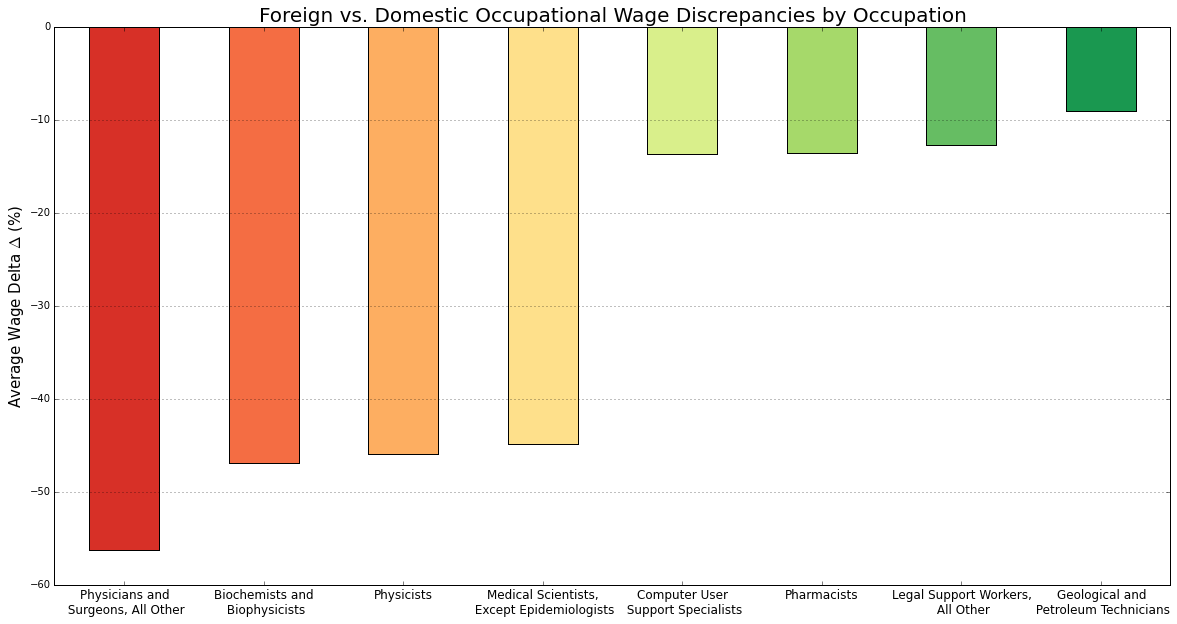

In [8]:
# Only occupations with at least 100 applicants will be examined in this graph.

delta_grouped_by_job = certified_delta_df.groupby(["LCA_CASE_SOC_NAME"])
valid_jobs = delta_grouped_by_job.size()[delta_grouped_by_job.size() > 100].keys()

valid_job_df = certified_delta_df[certified_delta_df["LCA_CASE_SOC_NAME"].isin(valid_jobs)]
delta_grouped_by_job = valid_job_df.groupby(["LCA_CASE_SOC_NAME"])
job_deltas = delta_grouped_by_job["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

job_values = job_deltas.head(4).values.tolist() + job_deltas.tail(4).values.tolist()
job_names = ["Physicians and \n Surgeons, All Other", "Biochemists and \n Biophysicists", "Physicists", 
            "Medical Scientists, \n Except Epidemiologists", "Computer User \n Support Specialists",
            "Pharmacists", "Legal Support Workers, \n All Other", "Geological and \n Petroleum Technicians"]

colors = ["#d73027", "#f46d43", "#fdae61", "#fee08b", "#d9ef8b", "#a6d96a", "#66bd63", "#1a9850"]

lefts = range(1,len(job_names)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))

plt.bar(lefts, [100*x for x in job_values], width=bar_widths, color = colors)
plt.grid(True, axis="y")
plt.title("Foreign vs. Domestic Occupational Wage Discrepancies by Occupation", fontsize=20)
plt.xticks([0.25+x for x in lefts], job_names, fontsize=12)
plt.xlim(0.75, 8.75)
plt.ylabel("Average Wage Delta $\Delta$ (%)", fontsize=15)

plt.show()

Again, we see doctors and scientists being paid **considerably** below average. In the case of Physicians and Surgeons, over 50% below the state average. How can this be possible, given that the purpose of the LCA is to ensure that foreign workers are paid similarly to their domestic counterparts? Are hospitals really paying foreign doctors less than half of their American colleagues? Do Stanford and Harvard discriminate against foreign scientists?

Remember that the metric we are using, Average Wage Delta, only shows the difference in wage based on occupation. This metric is limited because people in the same occupation can work in different industries and at different companies, some of which **are not available to foreign workers.** The biggest examples of these are private medical practices and government contractors.

In the case of medical professionals, those who work in or own their own private practice make considerably more money than those working at hospitals. However, this option is not availble to H1B applicants, as they require a company (such as a hospital) to sponsor them. As such, foreign doctors are forced to work the lowest-paying options in the field. This theory is supported by the fact that pharmacists, medical professionals who typically do not work at private practices, show some of the lowest Wage Deltas.

For scientists, the highest-paid positions are in private industry. However, these positions often involve working on government contracts (such as research positions at Lockheed Martin), which require US Citizenship. Because foreign workers are barred from these positions, their primary option is to work at the universities, which pay far less for the same work.

Much like when the footwear industry seemed to overpay foreign workers because of Nike, it is important to recognize the limitations of our metrics when performing analysis.

Finally, let's examine individual companies. Although we now know to expect universities and hospitals at the bottom, it would be interesting to see if any large companies pay foreign workers particularly well. For this final bit of analysis, I will only examine companies that filled at least 250 applications. Note that this excludes Nike, which would otherwise be far ahead of the competition.

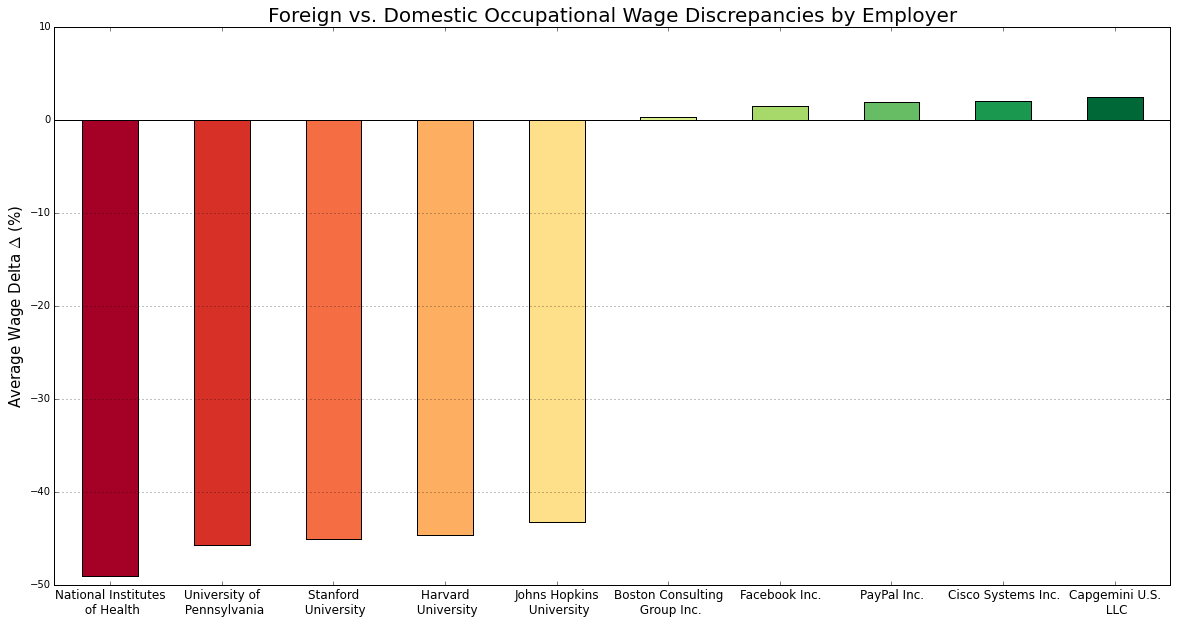

In [9]:
delta_grouped_by_company = certified_delta_df.groupby(["LCA_CASE_EMPLOYER_NAME"])
valid_companies = delta_grouped_by_company.size()[delta_grouped_by_company.size() > 250].keys()

valid_company_df = certified_delta_df[certified_delta_df["LCA_CASE_EMPLOYER_NAME"].isin(valid_companies)]
delta_grouped_by_company = valid_company_df.groupby(["LCA_CASE_EMPLOYER_NAME"])

company_deltas = delta_grouped_by_company["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

company_values = company_deltas.head().values.tolist() + company_deltas.tail().values.tolist()
company_names = ["National Institutes \n of Health", "University of \n Pennsylvania", "Stanford \n University", 
            "Harvard \n University", "Johns Hopkins \n University", "Boston Consulting \n Group Inc.", 
            "Facebook Inc.", "PayPal Inc.", "Cisco Systems Inc.", "Capgemini U.S. \n LLC"]

colors = ["#a50026", "#d73027", "#f46d43", "#fdae61", "#fee08b", "#d9ef8b", "#a6d96a", "#66bd63", "#1a9850", "#006837"]

lefts = range(1,len(company_names)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))

plt.bar(lefts, [100*x for x in company_values], width=bar_widths, color = colors)
plt.grid(True, axis="y")
plt.title("Foreign vs. Domestic Occupational Wage Discrepancies by Employer", fontsize=20)
plt.xticks([0.25+x for x in lefts], company_names, fontsize=12)
plt.xlim(0.75, 10.75)
plt.axhline(y=0, xmin=0, xmax=30000, color="black", ls="-", linewidth="1")
plt.ylabel("Average Wage Delta $\Delta$ (%)", fontsize=15)

plt.show()

As expected, universities and research institutions filled the bottom five slots. The top five large companies actually show a positive Wage Delta though. These particular companies are major players in the tech and consulting industries, but the overall data shows an interesting trend.

Almost all H1B applicants are working for less than their American counterparts. However, those in the private sector, particularly in manufacturing, tech, consulting, and finance, are paid much closer to the average of their occupational group. Those who take the biggest hit are physicians and scientists. Workers in those fields simply cannot earn their full potential while still requiring sponsorship.

### Conclusion - Wages
First and foremost, this data shows two overarching trends in H1B applicant wages:
1. They are typically paid more than the average American.
2. They are, in the vast majority of cases, paid less than Americans performing the same work.

The first trend can be explained by the tendency for companies to hire foreign workers for skilled positions (this will be explored in the next section). The latter is also expected because foreign workers are typically in a less advantageous position when negotiating their pay because their employer is sponsoring their Visa. While an American can simply take a better paying offer at another company, a foreign worker would have to reapply for an H1B to do so. That said, both of these trends are essentially common knowledge. What is interesting about this data are the wage trends in specific industries and occupations.

In particular, there are two groups of foreign workers making 40% less than their American equivalents: doctors and scientists. As discussed previously, this is likely due to the fact that their most profitable means of employment require citizenship, or at least permanent residency. I believe that this presents an opportunity for companies (particularly smaller ones) in similar sectors to hire highly skilled workers for a lower cost and for these foreign workers to earn more.

US companies are known to hire workers with advanced degrees from sometimes unrelated fields to perform high-skill labor. For years, Wall Street hired physicists and other scientists to perform quantitative analysis. Today, Silicon Valley has a similar demand for high-skill labor. Companies such as Google and Goldman Sachs are willing to pay these employees very high salaries, but smaller companies might have difficulty finding this sort of talent given the size of their bankrolls.

Consider a digital health startup in need of doctors. An experienced American doctor can make several hundred thousand dollars with their own private practice, which is more than most small companies can pay in salary. Foreign doctors, however, make considerably less at public hospitals and could potentially earn more by working at the startup. This mutually beneficial relationship between small companies and highly skilled foreigners can change some of the dynamics in places such as the Bay Area and is certainly worth exploring further.

## Part II - Applicant Density

Next, I wanted to understand more about the quantity of applications. Who's hiring? Where are these workers going? What will they be doing? Although the general trends are well known to most, the actual numbers are quite surprising in many cases.

Examining the number of applicants from just the top ten companies provides some surprising findings.

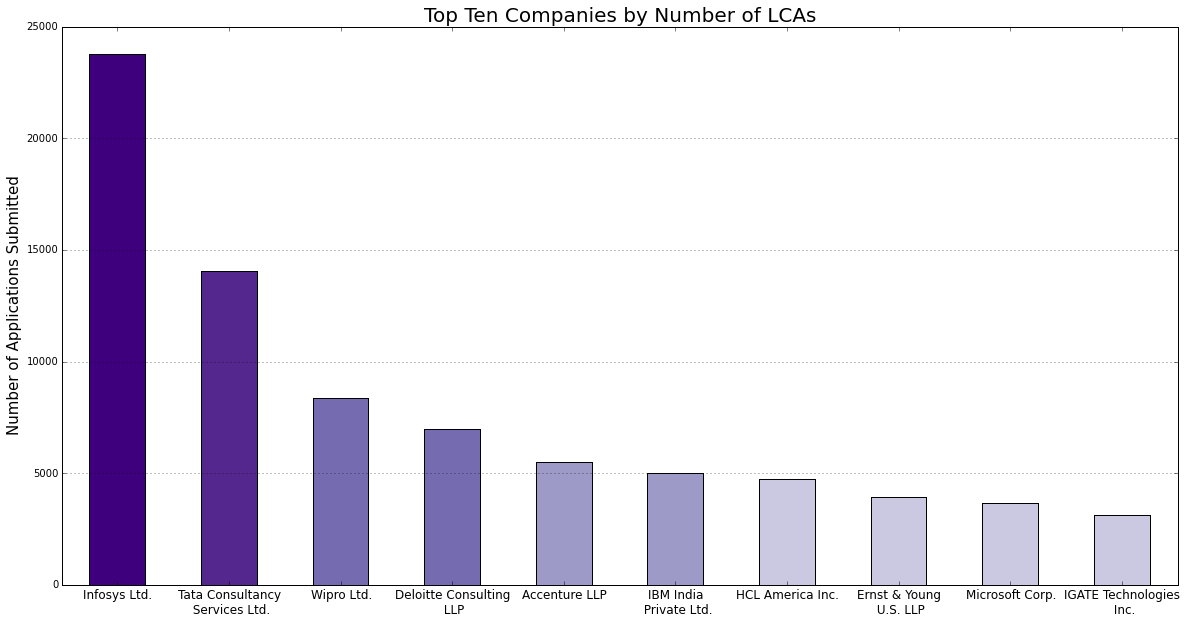

In [10]:
grouped_by_company = delta_df.groupby("LCA_CASE_EMPLOYER_NAME")
company_applications = grouped_by_company.size().order(ascending=False)
top_10_app_companies = company_applications.head(10)
top_10_app_company_values = top_10_app_companies.values
top_10_app_company_names = ["Infosys Ltd.", "Tata Consultancy \n Services Ltd.", "Wipro Ltd.", 
                            "Deloitte Consulting \n LLP", "Accenture LLP", "IBM India \n Private Ltd.", 
                            "HCL America Inc.", "Ernst & Young \n U.S. LLP", "Microsoft Corp.", 
                            "IGATE Technologies \n Inc."]

colors = ["#3f007d", "#54278f", "#756bb1","#756bb1","#9e9ac8","#9e9ac8","#cbc9e2","#cbc9e2","#cbc9e2","#cbc9e2"]

lefts = range(1,len(top_10_app_company_names)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))

plt.bar(lefts, top_10_app_company_values, width=bar_widths, color=colors)
plt.grid(True, axis="y")
plt.title("Top Ten Companies by Number of LCAs", fontsize=20)
plt.xticks([0.25+x for x in lefts], top_10_app_company_names, fontsize=12)
plt.xlim(0.75, 10.75)
plt.ylabel("Number of Applications Submitted", fontsize=15)

plt.show()

IT consultancies dominate by number of applications. Infosys, Tata Consultancy Services, Wipro, HCL America, and IGATE Technologies all primarily provide IT consulting services. Rounding out the top 10 are more general consultancies such as Deloitte and Accenture, an auditing firm (Ernst & Young), and more traditional technology companies (IBM India and Microsoft).

Another interesting fact is that five of the top ten companies are based in India (Infosys, Tata, Wipro, IBM India, and HCL).

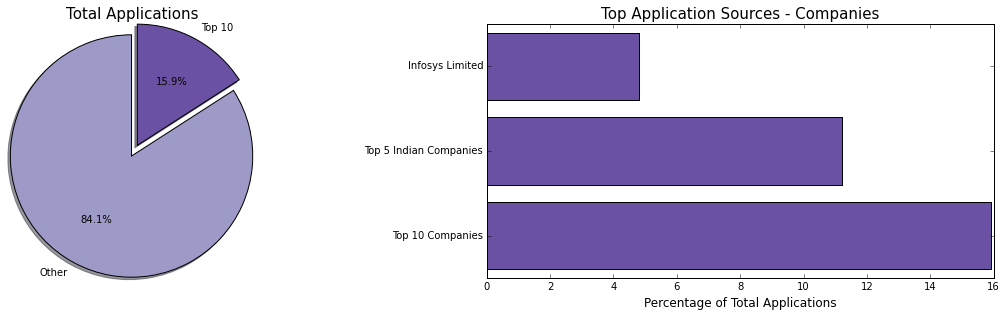

In [11]:
top_10_prop = round(top_10_app_company_values.sum()/float(len(delta_df)), 3)
indian_company_list = ["INFOSYS LIMITED", "TATA CONSULTANCY SERVICES LIMITED", "WIPRO LIMITED", 
                       "IBM INDIA PRIVATE LIMITED", "HCL AMERICA INC"]
indian_prop = round(top_10_app_companies[indian_company_list].sum()/float(len(delta_df)), 3)
infosys_prop = round(top_10_app_companies["INFOSYS LIMITED"]/float(len(delta_df)), 3)

plt.figure(figsize=(20,10))

plt.subplot(221)

labels = ["Other", "Top 10"]
sizes = [(1-top_10_prop), top_10_prop]
colors = ["#9e9ac8", "#6a51a3"]
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True,  startangle=90)
plt.axis('scaled')
plt.title("Total Applications", fontsize=15)

plt.subplot(222)                
vals = [top_10_prop*100, indian_prop*100, infosys_prop*100]
pos = range(1,len(vals)+1)
plt.barh(pos,vals, align='center', color="#6a51a3")
plt.title("Top Application Sources - Companies", fontsize=15)
plt.xlabel("Percentage of Total Applications", fontsize=12)
plt.yticks(pos, ("Top 10 Companies", "Top 5 Indian Companies", "Infosys Limited"))
plt.show()

Reviewing the number of applicants slated to work in each states highlights the most popular locations for foreign workers, some of which are ranked higher than I expected.

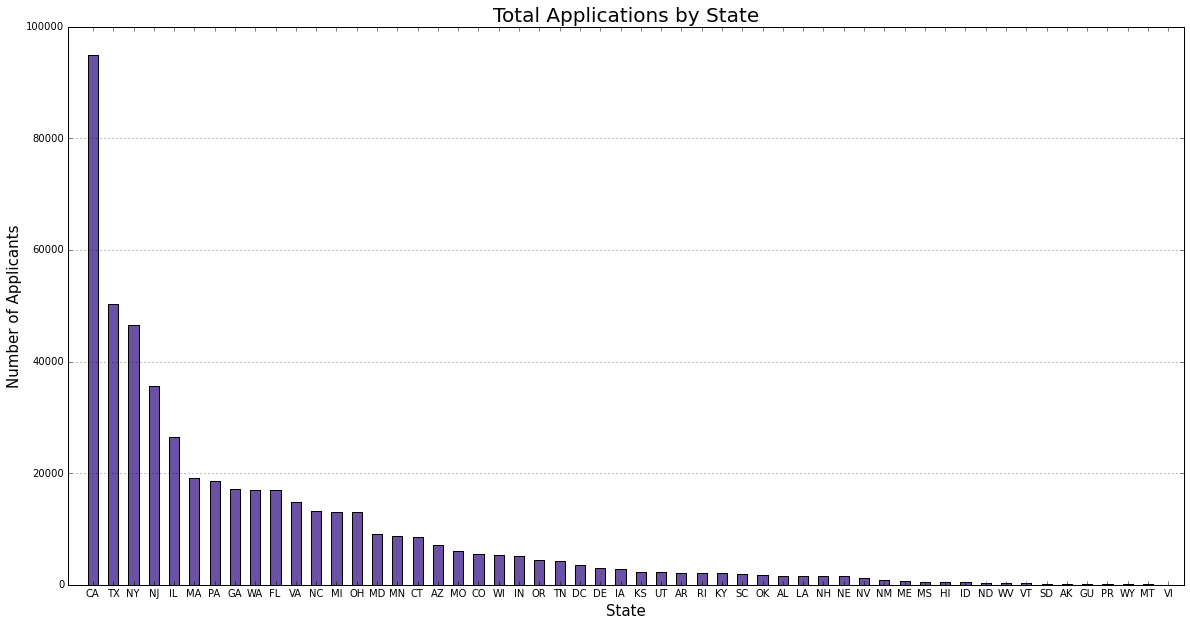

In [12]:
apps_grouped_by_state = delta_df.groupby(["STATE"])
apps_by_state = apps_grouped_by_state.size().order(ascending=False)
names = apps_by_state.keys().tolist()

lefts = range(1,len(apps_by_state)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))
    

plt.bar(lefts, apps_by_state.values, width=bar_widths, color="#6a51a3")
plt.grid(True, axis="y")
plt.title("Total Applications by State", fontsize=20)
plt.xlim(0, 55)
plt.xticks([0.25+x for x in lefts], names)
plt.xlabel("State", fontsize=15)
plt.ylabel("Number of Applicants", fontsize=15)

plt.show()

In [13]:
svg = open('Blank_US_Map.svg', 'r').read()

# Load into Beautiful Soup
soup = BeautifulSoup(svg, selfClosingTags=['defs','sodipodi:namedview'])
paths = soup.findAll('path')

colors = ["#f2f0f7", "#dadaeb","#bcbddc", "#9e9ac8", "#756bb1", "#6a51a3", "#3f007d"]

# State style
path_style = """font-size:12px;fill-rule:nonzero;stroke:#000000;stroke-opacity:1;
stroke-width:0.2;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;
marker-start:none;stroke-linejoin:bevel;fill:"""
 
# Color the counties based on Delta
for p in paths:
    try: state = p["id"]
    except: continue
    if state == "SP-": state = "MI"
    if state == "MI-": state = "MI"    
    try:
       size = apps_by_state[state]
    except:
       continue
         
    if  size > 80000:
        color_class = 6
    elif size > 40500:
        color_class = 5
    elif size > 13500:
        color_class = 4
    elif size > 4500:
        color_class = 3
    elif size > 1500:
        color_class = 2
    elif size > 500:
        color_class = 1
    else:
        color_class = 0
 
    color = colors[color_class]
    if state == "DC": soup.findAll('circle')[0]['style'] = path_style + color
    else: p['style'] = path_style + color
 
HTML(soup.prettify())

Naturally, the largest state (CA) has the most applicants, but some other states are very popular, such as New Jersey and Virginia. Note that the provided data specifies the state in which the applicant will work, so those numbers from New Jersey are not commuters that work in New York. This is especially surprising when considering the fact that New Jersey received more applicants than Illinois, where Chicago is located, and is the overall 4th ranked state by number of applicants. Furthermore, Virginia showed the second-greatest difference in wages (Delta) between foreign and domestic workers. I am curious as to what sorts of jobs H1B applicants are taking in NJ and VA, but first I want to examine the industries and occupations which are most common, then drill down from there.

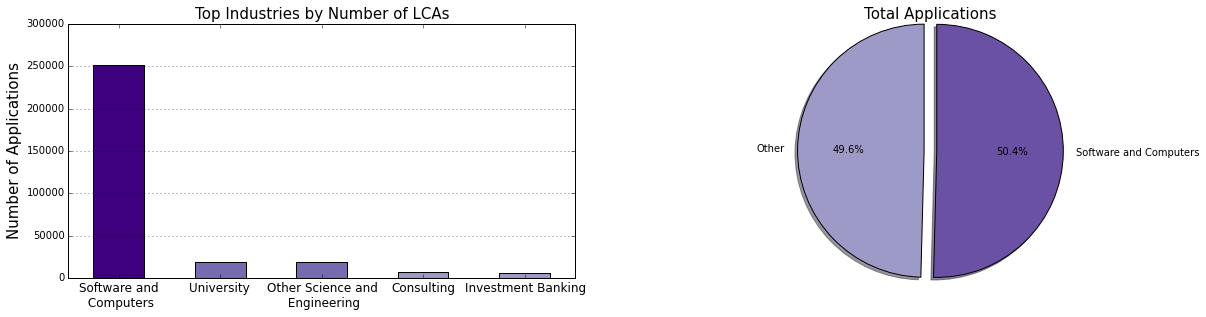

In [14]:
grouped_by_industry = delta_df.groupby("LCA_CASE_NAICS_CODE")
industry_applications = grouped_by_industry.size().order(ascending=False)

computer_industries = [541511, 541512, 541519, 541510, 54151]
eng_sci_industries = [541330, 5416]
universities = [611310]
consulting = [54161]
investment_banking = [523110]

total_applicants = float(len(delta_df))
computer_ind_apps = industry_applications[computer_industries].sum()
eng_sci_ind_apps = industry_applications[eng_sci_industries].sum()
university_apps = industry_applications[eng_sci_industries].sum()
consulting_apps = industry_applications[consulting].sum()
banking_apps = industry_applications[investment_banking].sum()
top_10_ind_apps = industry_applications.head(10).sum()

industry_values = [computer_ind_apps, university_apps, eng_sci_ind_apps, consulting_apps, banking_apps]
industry_names = ["Software and \n Computers", "University", "Other Science and \n Engineering", 
                  "Consulting", "Investment Banking"]

colors = ["#3f007d", "#756bb1", "#756bb1","#9e9ac8","#9e9ac8"]
lefts = range(1,len(industry_names)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))
plt.subplot(221)

plt.bar(lefts, industry_values, width=bar_widths, color=colors)
plt.grid(True, axis="y")
plt.title("Top Industries by Number of LCAs", fontsize=15)
plt.xticks([0.25+x for x in lefts], industry_names, fontsize=12)
plt.xlim(0.75, 5.75)
plt.ylabel("Number of Applications", fontsize=15)


plt.subplot(222)

comp_prop = computer_ind_apps/total_applicants
labels = ["Other", "Software and Computers"]
sizes = [(1-comp_prop), comp_prop]
colors = ["#9e9ac8", "#6a51a3"]
explode = (0, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True,  startangle=90)
plt.axis('scaled')
plt.title("Total Applications", fontsize=15)

plt.show()


Although I originally pulled the data from the top ten industries (by NAICS Code), I combined industries that were very similar to each other before analyzing the data. I had expected the software and computer companies to be a large source of applications, I did not expect them to account for over **half** of all applications in 2014. Universities comprise a fairly large section of the applicant pool as well, but tech absolutely dwarfs all other industries by a massive margin.

Examining the density of applications by occupation type shows the same trend.

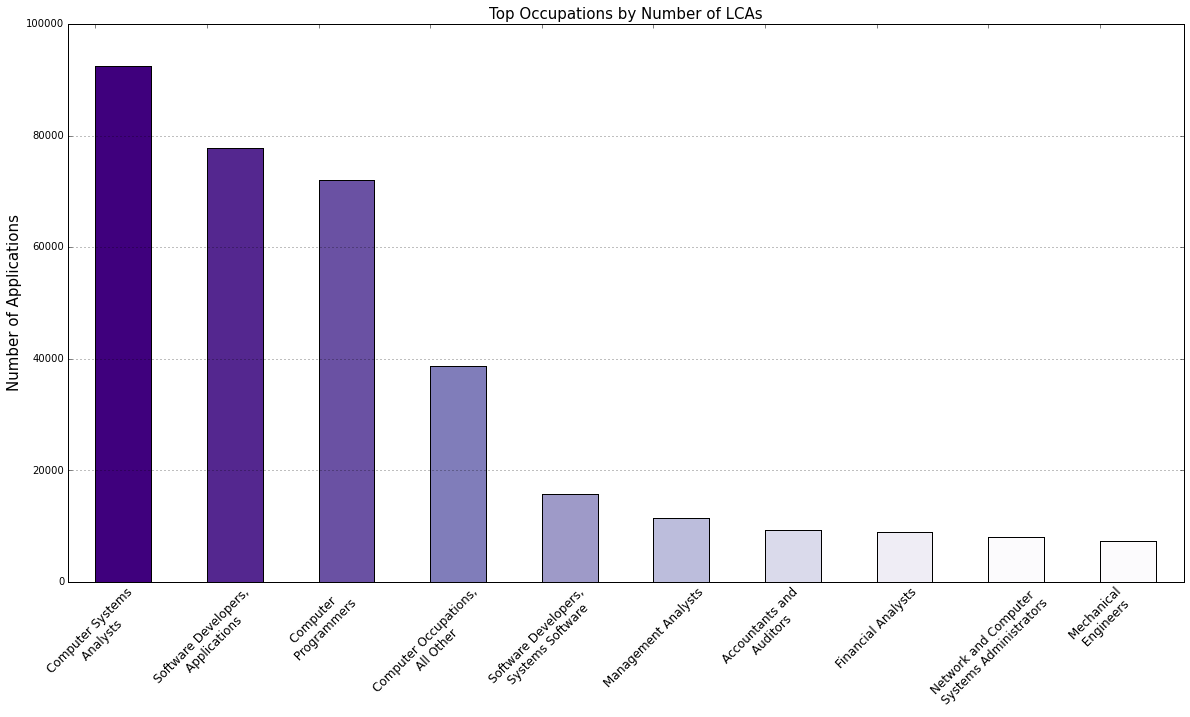

In [15]:
grouped_by_job = delta_df.groupby("LCA_CASE_SOC_NAME")
job_applications = grouped_by_job.size().order(ascending=False)
top_10_jobs = job_applications.head(10)
job_names = ["Computer Systems \n Analysts", "Software Developers, \n Applications", "Computer \n Programmers", 
             "Computer Occupations, \n All Other", "Software Developers, \n Systems Software", "Management Analysts",                           
             "Accountants and \n Auditors", "Financial Analysts", "Network and Computer \n Systems Administrators",     
             "Mechanical \n Engineers"]

colors = ["#3f007d", "#54278f", "#6a51a3","#807dba","#9e9ac8", "#bcbddc", "#dadaeb", "#efedf5", "#fcfbfd", "#fcfbfd"]

lefts = range(1,len(top_10_jobs)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))

plt.bar(lefts, top_10_jobs.values, width=bar_widths, color=colors)
plt.grid(True, axis="y")
plt.title("Top Occupations by Number of LCAs", fontsize=15)
plt.xticks(lefts, job_names, fontsize=12, rotation=45)
plt.xlim(0.75, 10.75)
plt.ylabel("Number of Applications", fontsize=15)

plt.show()

As expected, the most popular occupations are computer or software related. Finally, I can bring all of this data together and see if there are any interesting trends involving the states of New Jersey and Virginia. I will perform this analysis by comparing the number of workers in the top five occupations applying to work in each state. I will also examine the numbers for California, Texas, and New York (the top 3 states in total applications) for comparison. However, I will not use raw numbers in this case, as the sheer sizes of California and Texas will cause them to dominate the observed outputs. Instead, I will examine the number of applicants per capita in each state.

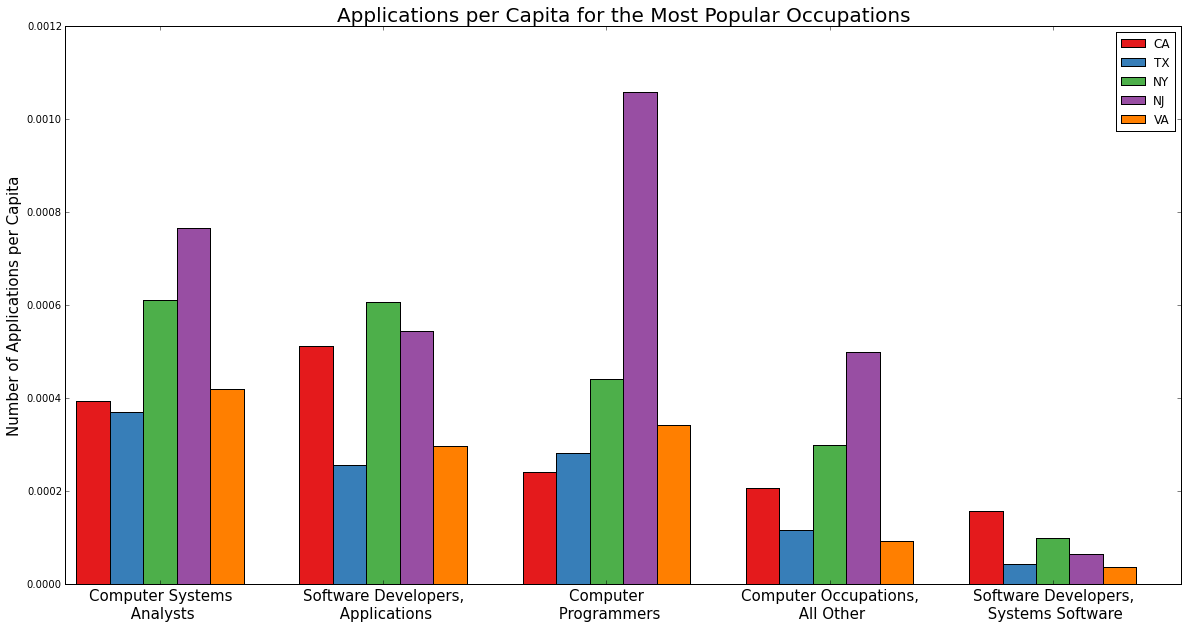

In [16]:
CA_POP = 38800000.
TX_POP = 26960000.
NY_POP = 8400000.
NJ_POP = 8930000.
VA_POP = 8326000.

job_1_df = delta_df[delta_df["LCA_CASE_SOC_NAME"] == "Computer Systems Analysts"]
job_2_df = delta_df[delta_df["LCA_CASE_SOC_NAME"] == "Software Developers, Applications"]
job_3_df = delta_df[delta_df["LCA_CASE_SOC_NAME"] == "Computer Programmers"]
job_4_df = delta_df[delta_df["LCA_CASE_SOC_NAME"] == "Computer Occupations, All Other"]
job_5_df = delta_df[delta_df["LCA_CASE_SOC_NAME"] == "Software Developers, Systems Software"]

df_list = [job_1_df, job_2_df, job_3_df, job_4_df, job_5_df,]
job_names = ["Computer Systems \n Analysts", "Software Developers, \n Applications", "Computer \n Programmers", 
             "Computer Occupations, \n All Other", "Software Developers, \n Systems Software"]

ca_data = [(x["STATE"] =="CA").sum()/CA_POP for x in df_list]
tx_data = [(x["STATE"] =="TX").sum()/TX_POP for x in df_list]
ny_data = [(x["STATE"] =="NY").sum()/NY_POP for x in df_list]
nj_data = [(x["STATE"] =="NJ").sum()/NJ_POP for x in df_list]
va_data = [(x["STATE"] =="VA").sum()/VA_POP for x in df_list]


lefts = range(1,len(job_names)+1)
lefts = np.arange(len(job_names))
bar_widths = 0.15

plt.figure(figsize=(20,10))


ca_rects = plt.bar(lefts+.05, ca_data, width=bar_widths, color="#e41a1c", label="CA")
tx_rects = plt.bar(lefts+bar_widths+.05, tx_data, width=bar_widths, color="#377eb8", label="TX")
ny_rects = plt.bar(lefts+bar_widths*2+.05, ny_data, width=bar_widths, color="#4daf4a", label="NY")
nj_rects = plt.bar(lefts+bar_widths*3+.05, nj_data, width=bar_widths, color="#984ea3", label="NJ")
va_rects = plt.bar(lefts+bar_widths*4+.05, va_data, width=bar_widths, color="#ff7f00", label="VA")

plt.title("Applications per Capita for the Most Popular Occupations", fontsize=20)
plt.xticks(lefts+bar_widths*2.5+0.05, job_names, fontsize=15)

plt.ylabel("Number of Applications per Capita", fontsize=15)
plt.legend()

plt.show()

It turns out that New Jersey actually receives a very large number of foreign Computer Programmers relative to its population. Virginia beats Texas in most of these categories as well, and even California in number of programmers, but is not as much of a standout as New Jersey. This metric is a little unfair to California due to its large population, but that does not detract from the fact that New Jersey is seeing a large influx of foreign tech-talent. Given this data, it may be viable for some medium sized companies in need of programmers to consider expanding to the Garden State, especially considering that NJ had one of the greatest Wage Deltas (from Section I) of any state.

###Conclusion - Density

To me, the most surprising fact about applicant density is that over 50% of applicants are in computer-related industries. While this does not necessarily mean that 50% of H1B visas are awarded to computer and software professionals (the LCA is just one part of the H1B application process), it does provide a sense of where most of the demand is. While on the topic of demand, I also found the sheer volume of applications from some companies fascinating. Infosys, for example, was the source of nearly 1 in 20 LCA applications for the *entire* country in 2014. While the dominance of tech in hiring foreign workers may not be new information for many, the information extracted in this section can serve as a basis for future analysis. One could gain insights about the future performance of a company or industry by examining their foreign hiring trends across several years, for example.